### Detection of Bot/Malware Generated Network Traffic  (using the CTU-13 dataset): Data exploration

Malware traffic is often hard to detect as it uses real users' PC or browsers in order to generate fraudulent activity and Spam. This notebook shows how to build a simple supervised model that will be trained to detect malware based traffic in a network traffic log or capture. When the model flags an IP as generating malware based spam and fraudulent activity  it can be listed for quarantine or further analysis. 

##### This notebook first explores the data and then divides it according to the label in order to examine the distribution of values over the two lables. Also, see the modeling notebook which does the actual modeling and evaluation.

##### This notebook gives a broad overview of the data exploration process, a more detailed and documented version can be found here:

About the Data Set
The Dataset used here is part of a larger dataset (named CTU-13) which records 4 hours of network traffic in a computer network of a university department in the CTU University, Czech Republic. The researchers that created the dataset infected one of the computers in the network in a malware that generates ClickFraud and Spam activity. The traffic was recorded by a traffic analytics tool which captured malware-based activity generated by the infected PC in addition to normal traffic. Since the infected computer is known, the data is labeled and the purpose of the project is to present a supervised classification model.

https://github.com/Hurence/logisland-flow-analytics-ml-jobs/blob/master/README.md

### Initial Data Exploration

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display
%matplotlib inline

In [4]:
df_raw = pd.read_csv(r'C:\Users\alon\OneDrive\Documents\Coursera-ML\Sample2Capture.csv')
print(df_raw.shape)


(372715, 15)


In [5]:
## Since we know the infected system IP addr we can classifiy the dataset.
# We will create a column named 'Bot' that will have the value 1 for bot based traffic and otherwise 0

infected_addr = "147.32.84.165"
df_raw["Bot"] = np.where(df_raw['SrcAddr'] == infected_addr, 1, 0)
#cleanup
df_raw["dTos"] = df_raw["sTos"].fillna(-1)
df_raw["sTos"] = df_raw["sTos"].fillna(-1)
df_raw = df_raw.drop(columns=['Sport','Dport','StartTime','Label'])

In [6]:
display(df_raw.head())

,Dur,Proto,SrcAddr,Dir,DstAddr,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Bot
0,0.431491,tcp,147.32.85.84,->,209.239.114.244,FSPA_FSPA,0.0,0.0,11,3857,825,0
1,0.416365,tcp,147.32.85.84,->,209.239.114.77,FSPA_FSPA,0.0,0.0,10,1504,923,0
2,0.465491,tcp,147.32.85.84,->,75.101.142.37,FSPA_FSA,0.0,0.0,8,1949,1381,0
3,0.000998,udp,98.119.30.20,<->,147.32.84.229,CON,0.0,0.0,2,138,78,0
4,0.002263,udp,79.131.193.0,<->,147.32.84.229,CON,0.0,0.0,2,525,465,0


In [7]:
# Each row in the dataset records parsed network requests, responses, and messages.
# The row above records a a request sent from  [147.32.85.84]:[39592] to  [209.239.114.244]:[80] using [TCP] protocol.
# The request had a certain duration ([Dur]), [State]  and number of packets and bytes that were sent 
# [SrcBytes, TotBytes, TotPkts]. 
# The NetFlow analyzer adds a certain [Label] that labels the data  
# while telling us whether it was generated by a malware bot.  
# The purpose is to do this classification based on the data itself



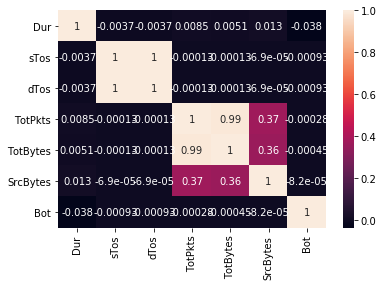

In [8]:
sns.heatmap(df_raw.corr(), annot=True)

#### The correlation is not impressive. There are, however, certain trends in the data can help us to classify it. 


In [9]:
# The correlation is not impressive. 
# we do notice that, as expected, TotBytes and TotPackets are correlated and therefore one should be removed.
# we will now try to see whether certain trends in the data can help us to classify it. 
#First we create 2 datasets of the normal and bot traffic
number_of_bots_rows = len(df_raw[df_raw['Bot'] == 1].index)
number_of_reg_rows = len(df_raw[df_raw['Bot'] == 0].index)

print(f"Number of bot requests in the data:{number_of_bots_rows} \
\nNumber of normal requests in the data:{number_of_reg_rows}")


Number of bot requests in the data:2691 
Number of normal requests in the data:370024


#### We'll divide our dataset to bot generated traffic and normal traffic and try to identify trends


In [10]:
bots_data = df_raw[df_raw['Bot'] == 1] #data set that records bots traffic 
nrml_unbalanced = df_raw[df_raw['Bot'] == 0]#data set that records normal traffic 

In [11]:
#We define a function that takes two datasets and plot them one next to the other

from matplotlib.ticker import FormatStrFormatter

def compare_two_dist(bot_traffic, normal_traffic, title):
    f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,7), sharey=False, sharex=False)
    sns.violinplot(data=bot_traffic,  inner="points", ax=ax1)
    sns.violinplot(data=normal_traffic,  inner="points", ax=ax2)
    ax1.set_ylim(bottom=np.amin(bot_traffic))
    ax2.set_ylim(bottom=np.amin(normal_traffic))
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.set_title('Regular Traffic')
    ax1.set_title('Bot Traffic')
    f.suptitle(title, fontsize=16)
    plt.show()
    
def get75Percentile(data, field):
    stats = data[field].describe()
    return data[field].loc[(data[field] < stats[6] + 1)].values.tolist()

In [12]:
# Start with the var SrcBytes
bot_stats = bots_data["SrcBytes"].describe()
nrml_stats = nrml_unbalanced["SrcBytes"].describe()
print(bot_stats)
print(nrml_stats)



count      2691.000000
mean       1574.726124
std       14155.776651
min          60.000000
25%         186.000000
50%         186.000000
75%         186.000000
max      241742.000000
Name: SrcBytes, dtype: float64
count    3.700240e+05
mean     1.727916e+03
std      1.592921e+05
min      0.000000e+00
25%      7.800000e+01
50%      8.200000e+01
75%      2.880000e+02
max      6.033451e+07
Name: SrcBytes, dtype: float64


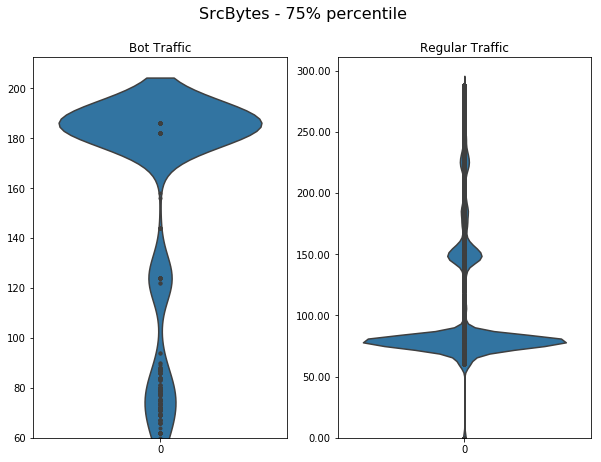

In [14]:
# We see a lot of variability and outliers, so lets plot all the data under the 75% percentile.
# we choose a violine plot to see peaks in the data rather then just general stats. 
# "In a violin plot, On each side of the gray line is a kernel density estimation to show the distribution shape of the data.
# Wider sections of the violin plot represent a higher probability that members of the population will 
# take on the given value; 

bot_p75 = get75Percentile(bots_data, "SrcBytes")
nrml_p75 = get75Percentile(nrml_unbalanced, "SrcBytes")
compare_two_dist(bot_p75,nrml_p75, "SrcBytes - 75% percentile")

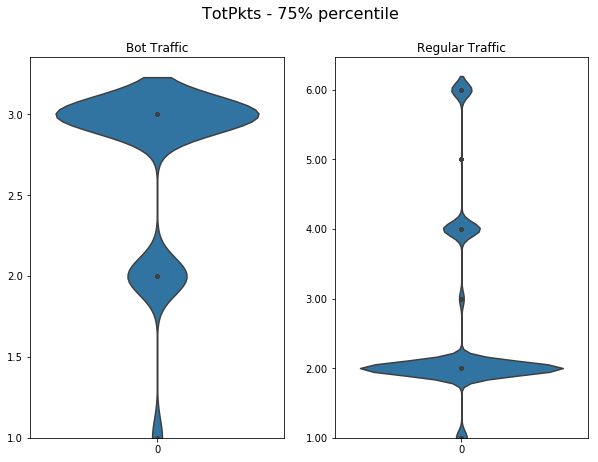

In [25]:
#And now TotPkts
bot_p75 = get75Percentile(bots_data, "TotPkts")
nrml_p75 = get75Percentile(nrml_unbalanced, "TotPkts")
compare_two_dist(bot_p75,nrml_p75, "TotPkts - 75% percentile")

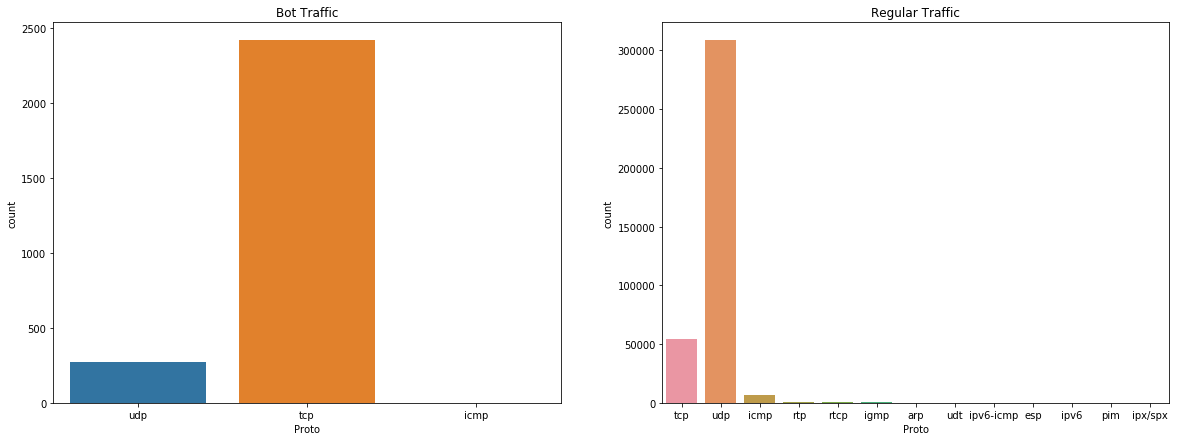

In [26]:
# Plot Protocl feature

b_freq_val = bots_data["Proto"].value_counts() #get a list of each protcol and its freq in the bot traffic
n_freq_val = nrml_unbalanced["Proto"].value_counts() #get a list of each protcol and its freq in the normal traffic

f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,7), sharey=False, sharex=False)
sns.countplot(x="Proto", data=bots_data, ax=ax1)
sns.countplot(x="Proto", data=nrml_unbalanced, ax=ax2)
ax2.set_title('Regular Traffic')
ax1.set_title('Bot Traffic')
plt.show()

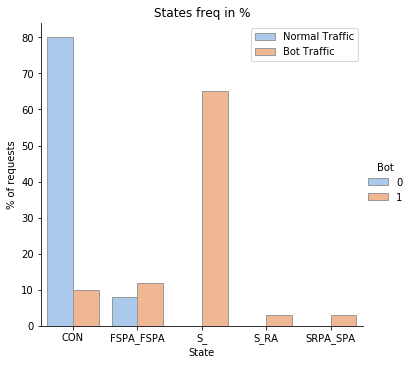

In [67]:
# The State field 

state_freq = df_raw["State"].value_counts()

# get the freq table of the State in the Bot traffic
b_state_freq = bots_data["State"].value_counts() 

 # get the freq table of the State in the Normal traffic
n_state_freq = nrml_unbalanced["State"].value_counts()

_temp = pd.DataFrame(columns=['State','Bot']) # create a dataframe that holds the freq for each type

for state in state_freq.index: 
    if(state in b_state_freq.index and state in n_state_freq.index):
        b_part  = b_state_freq[state]/bots_data["State"].size * 100 # get percentage of the data
        n_part = n_state_freq[state]/nrml_unbalanced["State"].size * 100 # get percentage of the data
        if(b_part > 3 or n_part > 3): #only take the meaningful ones that are more than %3
            for i in range(b_part.astype(np.int64)):
                _temp = _temp.append({'Bot':1,'State':state}, ignore_index=True)
            for i in range(n_part.astype(np.int64)):
                _temp = _temp.append({'Bot':0,'State':state}, ignore_index=True)
             


p1  = sns.catplot(x="State", hue="Bot", kind="count",palette="pastel", edgecolor=".6", data=_temp)
plt.title('States freq in %')
plt.ylabel('% of requests')
plt.legend(('Normal Traffic', 'Bot Traffic'), loc='upper right')
plt.show()            
            
            



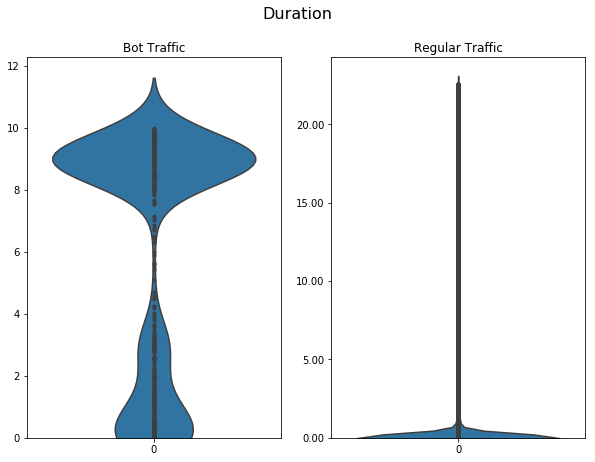

In [28]:
# We see that most data lies in the 75% and a lot of outliers lets plot the 75%
bot_p75 = get75Percentile(bots_data, "Dur")
nrml_p75 = get75Percentile(nrml_unbalanced, "Dur")

compare_two_dist(bot_p75, nrml_p75,"Duration")